In [1]:
import os
import ROOT
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from Data2Array import Data2Array,Array2Data
import argparse
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

Welcome to JupyROOT 6.22/00


In [2]:
labels = ['ptJ1','ptJ2','invmass','DRJ1J2','etaJ1','etaJ2']
#labels = labels+['pTDJ1','pTDJ2','LHAJ1','LHAJ2','e05J1','e05J2','s2J1','s2J2','pmJ1','pmJ2','tmJ1','tmJ2','widthJ1','widthJ2','girthJ1','girthJ2']

In [3]:
filenames =['pp2jj_SMbkg-Nev2e6-ptJetMin700-antiktR0.4-zcut0.1-beta1.0.root','pp2coloron2_qq-Nev2e6-ptJetMin700-antiktR0.4-zcut0.1-beta1.0.root']

In [6]:
data = Data2Array('../data/Ntuples',filenames,labels,(0,10000))
data_ar = data.load_df()

loading data from ../data/Ntuples/pp2jj_SMbkg-Nev2e6-ptJetMin700-antiktR0.4-zcut0.1-beta1.0.root
loading data from ../data/Ntuples/pp2coloron2_qq-Nev2e6-ptJetMin700-antiktR0.4-zcut0.1-beta1.0.root


In [7]:
#Creating Training,Test and Validation samples
traindataset_full,testdataset = train_test_split(data_ar,test_size=0.1,random_state=42)
traindataset,valdataset = train_test_split(traindataset_full,test_size=0.2,random_state=42)
trainData = copy.deepcopy(traindataset)
valData = copy.deepcopy(valdataset)


X_train,X_val = trainData.drop('target',axis=1).to_numpy(dtype='float64'),valData.drop('target',axis=1).to_numpy(dtype='float64')
y_train,y_val = trainData['target'].to_numpy(dtype='float64'),valData['target'].to_numpy(dtype='float64')
X_test,y_test = testdataset.drop('target',axis=1).to_numpy(dtype='float64'),testdataset['target']


In [8]:
#TransForming Data
num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy="median")),
    ('std_scaler',StandardScaler()),
])
encoder = OneHotEncoder()

X_train_tr,X_val_tr = num_pipeline.fit_transform(X_train),num_pipeline.fit_transform(X_val)
y_train_tr,y_val_tr = encoder.fit_transform(trainData[['target']]).toarray(),encoder.fit_transform(valData[['target']]).toarray()
X_test_ = num_pipeline.fit_transform(X_test)
y_test_ = encoder.fit_transform(testdataset[['target']]).toarray()
print('Label dims: ',X_train_tr.shape,'   Output dims: ',y_train_tr.shape)


Label dims:  (1191381, 6)    Output dims:  (1191381, 2)


In [13]:
#Tuning DNN model

def build_model(n_hidden=1,n_neurons=30,learning_rate=3e-3,input_shapes=[6]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shapes))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='relu'))
    model.add(keras.layers.Dense(2,activation='sigmoid'))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse",optimizer=optimizer)
    return model

In [14]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [15]:
len(labels)

6

In [16]:
keras_reg.fit(X_train_tr,y_train,epochs=10,validation_data=(X_val_tr,y_val),callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/10
37231/37231 [==============================] - 78s 2ms/step - loss: 0.1858 - val_loss: 0.1643
Epoch 2/10
37231/37231 [==============================] - 78s 2ms/step - loss: 0.1600 - val_loss: 0.1559
Epoch 3/10
37231/37231 [==============================] - 79s 2ms/step - loss: 0.1554 - val_loss: 0.1532
Epoch 4/10
37231/37231 [==============================] - 79s 2ms/step - loss: 0.1533 - val_loss: 0.1515
Epoch 5/10
37231/37231 [==============================] - 80s 2ms/step - loss: 0.1518 - val_loss: 0.1501
Epoch 6/10
37231/37231 [==============================] - 77s 2ms/step - loss: 0.1505 - val_loss: 0.1489
Epoch 7/10
37231/37231 [==============================] - 76s 2ms/step - loss: 0.1494 - val_loss: 0.1479
Epoch 8/10
37231/37231 [==============================] - 76s 2ms/step - loss: 0.1486 - val_loss: 0.1471
Epoch 9/10
37231/37231 [==============================] - 77s 2ms/step - loss: 0.1479 - val_loss: 0.1465
Epoch 10/10
37231/37231 [==============================

In [17]:
mse_test = keras_reg.score(X_test_,y_test_)

5171/5171 [==============================] - 9s 2ms/step - loss: 0.3494


In [18]:
param_distribs={
    'n_hidden':[1,2,3,4],
    'n_neurons':np.arange(1,500),
    'learning_rate':reciprocal(3e-4,3e-2),
}

In [19]:
rnd_search_cv=RandomizedSearchCV(keras_reg,param_distribs,n_iter=10,cv=3)

In [20]:
rnd_search_cv.fit(X_train_tr,y_train,epochs=10,validation_data=(X_val_tr,y_val),callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/10
24821/24821 [==============================] - 60s 2ms/step - loss: 0.2101 - val_loss: 0.1913
Epoch 2/10
24821/24821 [==============================] - 59s 2ms/step - loss: 0.1840 - val_loss: 0.1767
Epoch 3/10
24821/24821 [==============================] - 60s 2ms/step - loss: 0.1726 - val_loss: 0.1677
Epoch 4/10
24821/24821 [==============================] - 60s 2ms/step - loss: 0.1654 - val_loss: 0.1621
Epoch 5/10
24821/24821 [==============================] - 60s 2ms/step - loss: 0.1611 - val_loss: 0.1587
Epoch 6/10
24821/24821 [==============================] - 60s 2ms/step - loss: 0.1584 - val_loss: 0.1565
Epoch 7/10
24821/24821 [==============================] - 60s 2ms/step - loss: 0.1566 - val_loss: 0.1550
Epoch 8/10
24821/24821 [==============================] - 58s 2ms/step - loss: 0.1554 - val_loss: 0.1540
Epoch 9/10
24821/24821 [==============================] - 60s 2ms/step - loss: 0.1544 - val_loss: 0.1531
Epoch 10/10
12411/12411 [==============================

Epoch 4/10
24821/24821 [==============================] - 35s 1ms/step - loss: 0.1899 - val_loss: 0.1866
Epoch 5/10
24821/24821 [==============================] - 36s 1ms/step - loss: 0.1849 - val_loss: 0.1820
Epoch 6/10
24821/24821 [==============================] - 33s 1ms/step - loss: 0.1808 - val_loss: 0.1782
Epoch 7/10
24821/24821 [==============================] - 36s 1ms/step - loss: 0.1773 - val_loss: 0.1749
Epoch 8/10
24821/24821 [==============================] - 36s 1ms/step - loss: 0.1743 - val_loss: 0.1721
Epoch 9/10
24821/24821 [==============================] - 33s 1ms/step - loss: 0.1717 - val_loss: 0.1697
Epoch 10/10
12411/12411 [==============================] - 12s 976us/step - loss: 0.1683
Epoch 1/10
24821/24821 [==============================] - 36s 1ms/step - loss: 0.2267 - val_loss: 0.2117
Epoch 2/10
24821/24821 [==============================] - 35s 1ms/step - loss: 0.2047 - val_loss: 0.1988
Epoch 3/10
24821/24821 [==============================] - 37s 1ms/step 

Epoch 8/10
24821/24821 [==============================] - 59s 2ms/step - loss: 0.1456 - val_loss: 0.1443
Epoch 9/10
24821/24821 [==============================] - 57s 2ms/step - loss: 0.1452 - val_loss: 0.1440
Epoch 10/10
12411/12411 [==============================] - 15s 1ms/step - loss: 0.1447
Epoch 1/10
24821/24821 [==============================] - 52s 2ms/step - loss: 0.2228 - val_loss: 0.1970
Epoch 2/10
24821/24821 [==============================] - 52s 2ms/step - loss: 0.1808 - val_loss: 0.1680
Epoch 3/10
24821/24821 [==============================] - 48s 2ms/step - loss: 0.1624 - val_loss: 0.1573
Epoch 4/10
24821/24821 [==============================] - 52s 2ms/step - loss: 0.1560 - val_loss: 0.1535
Epoch 5/10
24821/24821 [==============================] - 50s 2ms/step - loss: 0.1533 - val_loss: 0.1514
Epoch 6/10
24821/24821 [==============================] - 49s 2ms/step - loss: 0.1517 - val_loss: 0.1500
Epoch 7/10
24821/24821 [==============================] - 53s 2ms/step - 

12411/12411 [==============================] - 15s 1ms/step - loss: 0.1485
Epoch 1/10
24821/24821 [==============================] - 44s 2ms/step - loss: 0.2232 - val_loss: 0.1989
Epoch 2/10
24821/24821 [==============================] - 47s 2ms/step - loss: 0.1851 - val_loss: 0.1740
Epoch 3/10
24821/24821 [==============================] - 41s 2ms/step - loss: 0.1669 - val_loss: 0.1595
Epoch 4/10
24821/24821 [==============================] - 46s 2ms/step - loss: 0.1568 - val_loss: 0.1532
Epoch 5/10
24821/24821 [==============================] - 43s 2ms/step - loss: 0.1531 - val_loss: 0.1509
Epoch 6/10
24821/24821 [==============================] - 47s 2ms/step - loss: 0.1514 - val_loss: 0.1497
Epoch 7/10
24821/24821 [==============================] - 44s 2ms/step - loss: 0.1504 - val_loss: 0.1487
Epoch 8/10
24821/24821 [==============================] - 55s 2ms/step - loss: 0.1495 - val_loss: 0.1479
Epoch 9/10
24821/24821 [==============================] - 46s 2ms/step - loss: 0.1488

24821/24821 [==============================] - 48s 2ms/step - loss: 0.1573 - val_loss: 0.1534
Epoch 4/10
24821/24821 [==============================] - 52s 2ms/step - loss: 0.1531 - val_loss: 0.1511
Epoch 5/10
24821/24821 [==============================] - 51s 2ms/step - loss: 0.1514 - val_loss: 0.1498
Epoch 6/10
24821/24821 [==============================] - 54s 2ms/step - loss: 0.1503 - val_loss: 0.1487
Epoch 7/10
24821/24821 [==============================] - 51s 2ms/step - loss: 0.1494 - val_loss: 0.1479
Epoch 8/10
24821/24821 [==============================] - 56s 2ms/step - loss: 0.1486 - val_loss: 0.1472
Epoch 9/10
24821/24821 [==============================] - 50s 2ms/step - loss: 0.1479 - val_loss: 0.1465
Epoch 10/10
12411/12411 [==============================] - 13s 1ms/step - loss: 0.1470


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fa168249310>, as the constructor either does not set or modifies parameter learning_rate

In [24]:
rnd_search_cv.best_params_

{'learning_rate': 0.01304080507013371, 'n_hidden': 3, 'n_neurons': 475}

In [25]:
rnd_search_cv.best_score_

-0.15756651759147644

In [31]:
model =rnd_search_cv.best_estimator_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

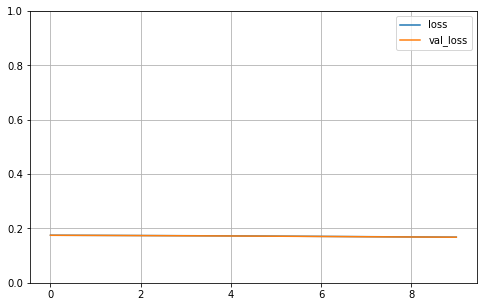

In [27]:
# #Learning Curves
pd.DataFrame(prefit.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
# plt.savefig('../plots/learning_Curves.png')
plt.show()


In [7]:
#DNN model
def build_model(n_hidden=1,n_neurons=30,learning_rate=3e-3,input_shapes=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shapes))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons,activation='relu',kernel_initializer="he_normal"))
    he_avg_init = keras.initializers.VarianceScaling(scale=2.,mode='fan_avg',distribution='uniform')
    model.add(keras.layers.Dense(2,activation='sigmoid',kernel_initializer=he_avg_init))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=['accuracy'])
    return model

l_rate =  0.01304080507013371

#Tuned Model
model = build_model(n_hidden=3,n_neurons=475,learning_rate=l_rate,input_shapes=len(labels))


2020-10-01 15:50:23.340087: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-10-01 15:50:23.481626: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1800000000 Hz
2020-10-01 15:50:23.492361: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fffdd333bf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-01 15:50:23.492915: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-10-01 15:50:23.501819: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
prefit = model.fit(X_train_tr,y_train,epochs=1,validation_data=(X_val_tr,y_val),callbacks=[keras.callbacks.EarlyStopping(patience=10)])

37231/37231 [==============================] - 191s 5ms/step - loss: 0.4236 - accuracy: 0.8075 - val_loss: 0.4088 - val_accuracy: 0.8171


In [9]:
y_pred = model.predict(X_test_)

In [10]:
y_out = np.array(y_test,dtype='float32')
y_pred

array([[0.7063225 , 0.19619861],
       [0.5586795 , 0.05687663],
       [0.43129814, 0.12285158],
       ...,
       [0.49909323, 0.19855192],
       [0.4417659 , 0.0430665 ],
       [0.5519167 , 0.0350956 ]], dtype=float32)

In [54]:
y_test

1270503    0
869728     0
839203     0
606202     1
314340     1
          ..
118704     1
901315     0
724600     0
946506     0
861798     0
Name: target, Length: 134957, dtype: object

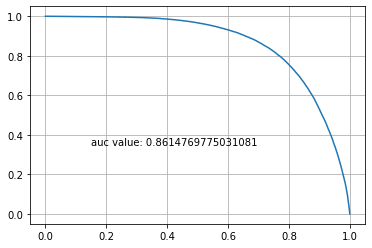

In [11]:
plt.plot(figsize=(6,5))
plt.grid(True)
fpr,tpr,th = roc_curve(y_true=y_out,y_score=y_pred[:,1])
auc = roc_auc_score(y_out,y_pred[:,1])
plt.plot(tpr,1-fpr)
plt.text(0.15,0.35,f'auc value: {auc}')
plt.show()


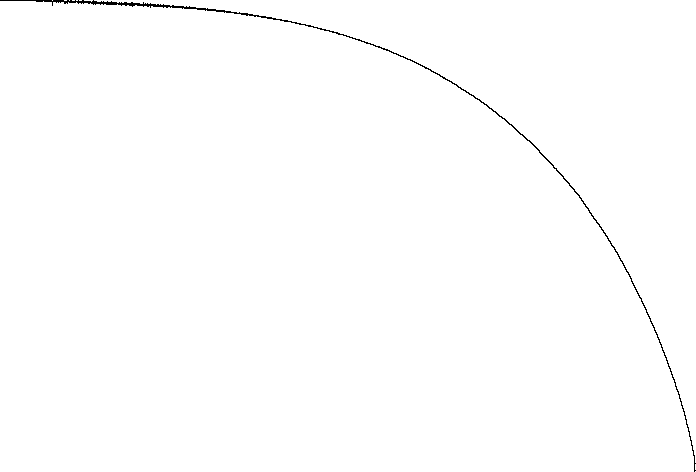

In [171]:
c = ROOT.TCanvas()
gr = ROOT.TGraph(fpr.size,tpr,1-fpr)
gr.Draw("C")
c.Draw()

In [182]:
fpr.size

48552

Text(0.5, 0, 'DNN response with JSS')

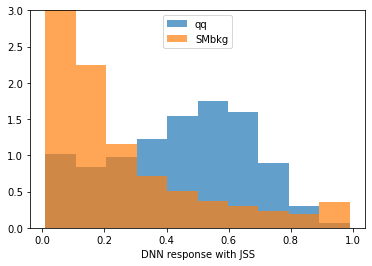

In [14]:
Bins =10
plt.plot(figsize=(6,5))
plt.hist(y_pred[:,0],bins=Bins,range=(0.01,0.99),density=True,alpha=0.7,label='qq')
plt.hist(y_pred[:,1],bins=Bins,range=(0.01,0.99),density=True,alpha=0.7,label='SMbkg')
plt.legend(loc='upper center')
plt.ylim(0,3)
plt.xlabel('DNN response with JSS')


In [111]:
m_inv = np.array(testdataset['invmass'],dtype=[('m_inv',np.float32)])
sig_score = y_pred[:,1].astype([('sig_score',np.float32)])

In [91]:
from root_numpy import array2root,array2tree

In [121]:
test_root = ROOT.TFile('test.root',"update")


In [120]:
test = array2tree(m_inv,'tree')
array2tree(sig_score,'tree')
test_root.Write()

1053

In [124]:
array2root(m_inv,'test_.root',treename='tree',mode='update')
array2root(sig_score,'test_.root',treename='tree',mode='update')

Warning in <TTree::SetEntries>: Tree branches have different numbers of entries, eg sig_score has 134957 entries while m_inv has 269914 entries.


In [125]:
test_file = ROOT.TFile('test.root','update')

In [126]:
test_file = array2root(m_inv,'test_.root',treename='tree',mode='update')

In [133]:
sig_df = testdataset.loc[testdataset['target']=='0']

In [134]:
sig_df

,ptJ1,ptJ2,invmass,DRJ1J2,etaJ1,etaJ2,pTDJ1,pTDJ2,LHAJ1,LHAJ2,...,s2J2,pmJ1,pmJ2,tmJ1,tmJ2,widthJ1,widthJ2,girthJ1,girthJ2,target
1270503,920.556030,694.270020,1728.776733,3.19922,-1.450070,-0.647956,0.407418,0.442950,0.249925,0.158206,...,0.004815,23,13,9,8,0.078307,0.029794,0.011820,0.001702,0
869728,977.276978,849.578003,1815.327881,2.95761,0.204744,0.154638,0.308062,0.271052,0.375982,0.387466,...,0.020248,49,60,26,32,0.191190,0.195617,0.087703,0.095123,0
839203,830.455017,740.653015,1714.205811,3.21874,-0.698874,-1.555030,0.229689,0.823940,0.379816,0.186277,...,0.001960,51,28,25,18,0.156358,0.052102,0.034489,0.012108,0
668350,723.604980,710.296997,1430.953857,2.28314,-0.380906,-1.362930,0.321829,0.717977,0.359688,0.222939,...,0.005012,38,34,24,19,0.158036,0.083569,0.064314,0.035901,0
1281403,909.685974,754.362976,1710.412720,3.12107,0.262633,-0.248330,0.599768,0.409279,0.162300,0.322845,...,0.010831,16,41,12,21,0.029551,0.119836,0.001464,0.026503,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722138,974.859985,873.965027,1857.237549,3.07251,-0.645853,-0.879272,0.271995,0.449791,0.228012,0.379112,...,0.020106,27,36,16,24,0.058282,0.176638,0.005178,0.078418,0
901315,880.844971,871.333984,2011.327026,3.30382,1.732070,0.657103,0.284619,0.269506,0.251780,0.437628,...,0.032669,54,63,27,46,0.086682,0.216576,0.024060,0.079883,0
724600,887.905029,884.276978,1810.455566,3.16580,0.165679,-0.249287,0.602745,0.264591,0.105069,0.425641,...,0.033674,11,60,9,26,0.014623,0.212068,0.000743,0.078100,0
946506,1436.229980,840.208984,2606.331543,3.32220,-0.746192,0.457095,0.413254,0.703787,0.100063,0.213073,...,0.002761,17,19,12,11,0.016331,0.053105,0.001726,0.006404,0


In [160]:
l1 = np.array([1,2,3])
l2 = np.array([4,5,6])
l = zip(l1,l2)

In [161]:
l_= list(l)
ar = np.array(l_,dtype=[('a','int32'),('b','int32')])

In [162]:
ar

array([(1, 4), (2, 5), (3, 6)], dtype=[('a', '<i4'), ('b', '<i4')])